In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

In [2]:
sys.path.insert(0, "/home/storage/hans/jax_reco")
from lib.cgamma import gamma_conv_jax_region1
from lib.cgamma import gamma_conv_jax_region3
from lib.cgamma import gamma_conv_jax_region4

In [3]:
from lib.plotting_tools import adjust_plot_1d
from lib.network import get_network_eval_fn
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs, transform_network_inputs

In [4]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco/data/network')

In [5]:
# Set choice of parameters.

dist = 2
z = -210
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_a, gamma_b = transform_network_outputs(y)

# index 1 is main component
gamma_a = gamma_a[1]
gamma_b = gamma_b[1]
#gamma_a = 3.5
#gamma_b = 0.8
sigma = 3

xmax = 5 * dist

print(gamma_a, gamma_b)

1.2639036039176479 1.5062730536905142


In [6]:
print("peak of original gamma at t =", (gamma_a - 1) / gamma_b, "ns")
print("critical transition at t =", gamma_b * sigma**2, "ns")

peak of original gamma at t = 0.17520303059996897 ns
critical transition at t = 13.556457483214627 ns


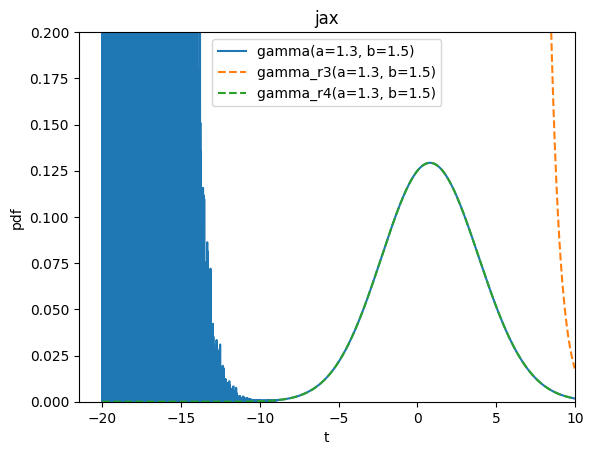

In [7]:
xvals = jnp.linspace(-20, xmax, 10000)
yvals_region1 = gamma_conv_jax_region1(xvals, gamma_a, gamma_b, sigma=sigma)
yvals_region3 = gamma_conv_jax_region3(xvals, gamma_a, gamma_b, sigma=sigma)
yvals_region4 = gamma_conv_jax_region4(xvals, gamma_a, gamma_b, sigma=sigma)

fig, ax = plt.subplots()
ax.plot(xvals, yvals_region1, label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f})')
ax.plot(xvals, yvals_region3, label=f'gamma_r3(a={gamma_a:.1f}, b={gamma_b:.1f})', linestyle='dashed')
ax.plot(xvals, yvals_region4, label=f'gamma_r4(a={gamma_a:.1f}, b={gamma_b:.1f})', linestyle='dashed')

ax.set_xlabel('t')
ax.set_ylabel('pdf')
ax.legend()
ax.set_title('jax')
ax.set_xlim(xmax=xmax)
ax.set_ylim([0.0, 0.2])
plt.show()

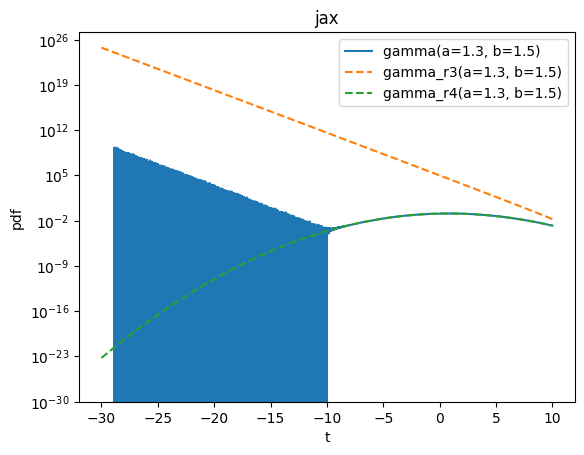

In [8]:
xvals = jnp.linspace(-30, xmax, 10000)
yvals_region1 = gamma_conv_jax_region1(xvals, gamma_a, gamma_b, sigma=sigma)
yvals_region3 = gamma_conv_jax_region3(xvals, gamma_a, gamma_b, sigma=sigma)
yvals_region4 = gamma_conv_jax_region4(xvals, gamma_a, gamma_b, sigma=sigma)

fig, ax = plt.subplots()
ax.plot(xvals, yvals_region1, label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f})')
ax.plot(xvals, yvals_region3, label=f'gamma_r3(a={gamma_a:.1f}, b={gamma_b:.1f})', linestyle='dashed')
ax.plot(xvals, yvals_region4, label=f'gamma_r4(a={gamma_a:.1f}, b={gamma_b:.1f})', linestyle='dashed')

ax.set_xlabel('t')
ax.set_ylabel('pdf')
ax.set_yscale('log')
ax.legend()
ax.set_title('jax')
ax.set_ylim(ymin=1.e-30)
plt.show()

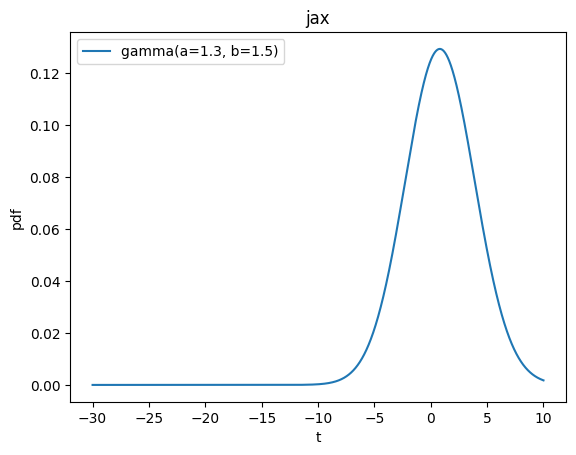

In [9]:
delta = 0.5
crit_x  =  gamma_b * sigma**2
yvals1 = jnp.where(xvals <= crit_x-0.5, yvals_region4, 0.0)
yvals2 = jnp.where(xvals >= crit_x+0.5, yvals_region3, 0.0)
yvals3 = jnp.where(jnp.logical_and(xvals < crit_x+0.5, xvals > crit_x-0.5),
                   yvals_region1, 0.0)

fig, ax = plt.subplots()
ax.plot(xvals, yvals1+yvals2+yvals3, label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f})')

ax.set_xlabel('t')
ax.set_ylabel('pdf')
#ax.set_yscale('log')
ax.legend()
ax.set_title('jax')
#ax.set_ylim(ymin=1.e-30)
plt.show()

In [10]:
@jax.jit
def cgamma_combined(x, a, b, sigma):
    delta = 0.5
    crit_x = b * sigma**2

    # x < crit_x - delta => region 4
    # x > crit_x + delta => region 5
    # else: exact evaluation => region 1

    yvals_region1 = gamma_conv_jax_region1(x, a, b, sigma=sigma)
    yvals_region4 = gamma_conv_jax_region4(x, a, b, sigma=sigma)
    yvals_region3 = gamma_conv_jax_region3(x, a, b, sigma=sigma)
    
    result4 = jnp.where(x <= crit_x-0.5, yvals_region4, 0.0)
    result3 = jnp.where(x >= crit_x+0.5, yvals_region3, 0.0)
    result1 = jnp.where(jnp.logical_and(x < crit_x+0.5, x > crit_x-0.5),
                       yvals_region1, 0.0)

    return result1 + result3 + result4

In [11]:
xvals = jnp.linspace(-30, xmax, 10000)
yvals_comb = cgamma_combined(xvals, gamma_a, gamma_b, jnp.float64(3.0))

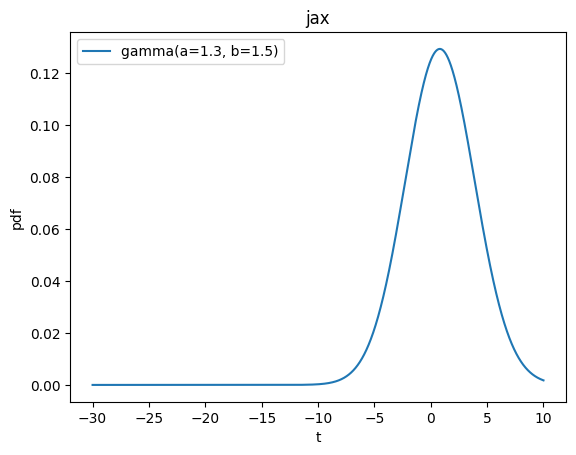

In [12]:
fig, ax = plt.subplots()
ax.plot(xvals, yvals_comb, label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f})')

ax.set_xlabel('t')
ax.set_ylabel('pdf')
ax.legend()
ax.set_title('jax')
plt.show()

In [13]:
yvals_comb

Array([5.82739023e-24, 5.90629012e-24, 5.98624769e-24, ...,
       1.76446515e-03, 1.75807520e-03, 1.75170594e-03], dtype=float64)

In [14]:
print(xvals)

[-30.        -29.9959996 -29.9919992 ...   9.9919992   9.9959996
  10.       ]


In [15]:
da = jax.jit(jax.grad(cgamma_combined, argnums=(0, 1, 2)))

In [16]:
da(200.0, gamma_a, gamma_b, jnp.float64(3.0))

(Array(nan, dtype=float64, weak_type=True),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64))

In [17]:
@jax.jit
def pdf_sum(x, a, b, sigma):
    return jnp.sum(cgamma_combined(x, a, b, sigma))

pdf_sum_grad = jax.jit(jax.grad(pdf_sum, argnums=(0, 1, 2)))

In [18]:
pdf_sum_grad(200.0, gamma_a, gamma_b, jnp.float64(3.0))

(Array(nan, dtype=float64, weak_type=True),
 Array(nan, dtype=float64),
 Array(nan, dtype=float64))

In [19]:
pdf_sum(xvals, gamma_a, gamma_b, jnp.float64(3.0))

Array(249.53678241, dtype=float64)

In [20]:
xvals

Array([-30.       , -29.9959996, -29.9919992, ...,   9.9919992,
         9.9959996,  10.       ], dtype=float64)

In [21]:
da = jax.jit(jax.grad(gamma_conv_jax_region3, argnums=(0, 1, 2)))

In [22]:
da(400.0, gamma_a, gamma_b, jnp.float64(3.0))

(Array(-7.8878407e-257, dtype=float64, weak_type=True),
 Array(3.44599861e-256, dtype=float64),
 Array(-2.02022776e-254, dtype=float64))

In [23]:
@jax.jit
def cgamma_combined_stable_gradient(x, a, b, sigma):
    # x < crit_x - delta => region 4
    # x > crit_x + delta => region 5
    # else: exact evaluation => region 1
    # makes a piecewise defined function
    # that ensures stable gradients.
    
    delta = 0.5
    crit_x = b * sigma**2

    cond_region1 = jnp.logical_and(x < crit_x+delta, x > crit_x-delta)
    x_region1 = jnp.where(cond_region1, x, crit_x)

    cond_region3 = x >= crit_x+delta
    x_region3 = jnp.where(cond_region3, x, crit_x+delta)

    cond_region4 = x <= crit_x-delta
    x_region4 = jnp.where(cond_region4, x, crit_x-delta)
    

    yvals_region1 = gamma_conv_jax_region1(x_region1, a, b, sigma=sigma)
    yvals_region3 = gamma_conv_jax_region3(x_region3, a, b, sigma=sigma)
    yvals_region4 = gamma_conv_jax_region4(x_region4, a, b, sigma=sigma)
    
    result1 = jnp.where(cond_region1, yvals_region1, 0.0)
    result3 = jnp.where(cond_region3, yvals_region3, 0.0)
    result4 = jnp.where(cond_region4, yvals_region4, 0.0)
    
    return result1 + result3 + result4


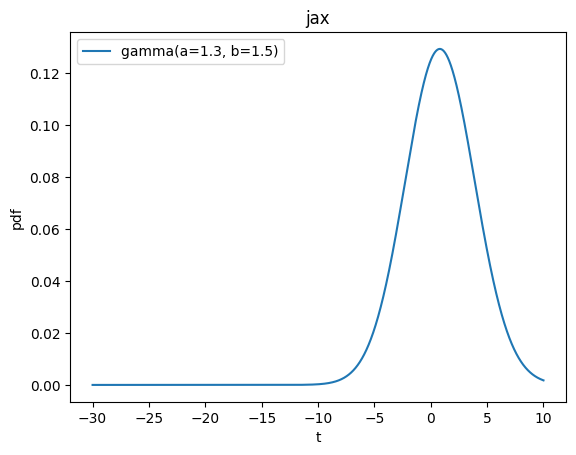

In [24]:
xvals = jnp.linspace(-30, xmax, 10000)
yvals_comb = cgamma_combined_stable_gradient(xvals, gamma_a, gamma_b, jnp.float64(3.0))

fig, ax = plt.subplots()
ax.plot(xvals, yvals_comb, label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f})')

ax.set_xlabel('t')
ax.set_ylabel('pdf')
ax.legend()
ax.set_title('jax')
plt.show()

In [25]:
da = jax.jit(jax.grad(cgamma_combined_stable_gradient, argnums=(0, 1, 2)))

In [35]:
da(1.0, gamma_a, gamma_b, jnp.float64(3.0))

(Array(-0.0026566, dtype=float64, weak_type=True),
 Array(-0.00110508, dtype=float64),
 Array(0.00315131, dtype=float64))

In [27]:
%timeit da(200.0, gamma_a, gamma_b, jnp.float64(3.0))

301 µs ± 3.79 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
